## Dog Vs Cat: A CNN based Dog/Cat Classifer 

# enviroment setup

In [2]:
import numpy as np
import os
import glob
import cv2
from collections import Counter
import random

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dropout, ELU
from keras.layers.convolutional import Cropping2D, Convolution2D, MaxPooling2D
from keras.layers.core import Lambda, Dense, Activation, Flatten
from keras.preprocessing.image import ImageDataGenerator


import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0)

TRAIN_DATA_PATH_LIST = ["./train"]
TEST_DATA_PATH_LIST = ["./test"]

LABEL_LIST = sorted(["dog", "cat"])

DO_VISUALIZE = True

/Users/zhaowenhao/anaconda/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/zhaowenhao/anaconda/envs/py3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# load and analysis data

one hot encoding:  {'dog': array([ 0.,  1.]), 'cat': array([ 1.,  0.])}
loading data from: ./train
total 12500 dog images loaded.
total 12500 cat images loaded.
total 25000 raw data samples loaded.
{(0.0, 1.0): 'dog', (1.0, 0.0): 'cat'}
most common dog image height:  [(374, 1400), (375, 1345), (500, 1040), (499, 993), (332, 153), (333, 152), (399, 150), (299, 130), (240, 123), (300, 122)]
most common dog image width:  [(500, 2486), (499, 2398), (350, 197), (400, 194), (399, 175), (375, 174), (299, 162), (319, 160), (320, 155), (300, 146)]
most common cat image height:  [(374, 1684), (375, 1614), (499, 846), (500, 804), (333, 166), (332, 155), (239, 149), (240, 130), (299, 108), (359, 89)]
most common cat image width:  [(499, 2914), (500, 2859), (349, 188), (300, 181), (350, 175), (319, 165), (320, 164), (299, 149), (399, 149), (400, 142)]


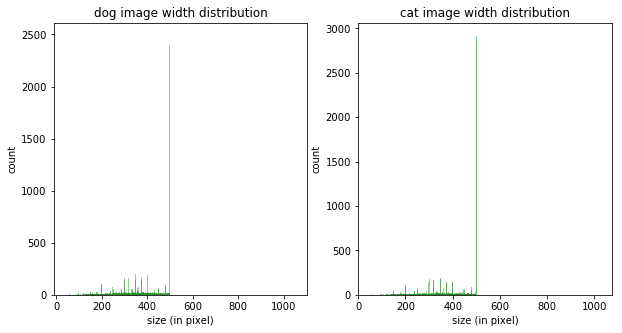

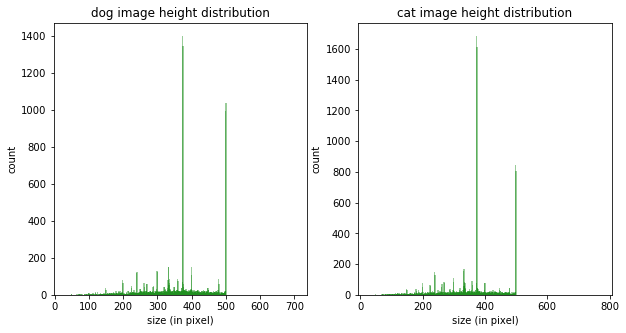

In [8]:
def label_one_hot_encoding(labe_list):
    encoder = LabelEncoder()
    transfomed_label = encoder.fit_transform(labe_list)
    one_hot_encoded_labels =  np_utils.to_categorical(transfomed_label)
    one_hot_label_dict = {}
    for i  in range(len(labe_list)):
        one_hot_label_dict[labe_list[i]] = one_hot_encoded_labels[i] 
    
    print("one hot encoding: ", one_hot_label_dict)
    return one_hot_label_dict
    



def load_samples(DATA_PATH, one_hot_encoding_dict):
    labels = one_hot_encoding_dict.keys()    
    samples = [] # [one_hot_label, image_path]
    temp_size = 0
    for dir in DATA_PATH: 
        print("loading data from: " + dir)
        for key in labels:           
            samples += [[one_hot_encoding_dict[key],file] for file in glob.glob(os.path.join(dir, key + '*.jpg'))]
            temp_size = len(samples) - temp_size    
            print("total " + str(temp_size) + " " + key + " images loaded.")
            temp_size = len(samples)
        
        print("total " + str(temp_size) + " raw data samples loaded.")
        
    return samples    



def raw_data_analysis(raw_sample_list, one_hot_encoding_dict):
    
    inverse_one_hot_encoding_dict = {tuple(v): k for k, v in one_hot_encoding_dict.items()}
    
    print(inverse_one_hot_encoding_dict)
    
    image_size_counter = {}   
    dimension_shape = ["height", "width"]
    
    for sample in raw_sample_list:   
        label = inverse_one_hot_encoding_dict[tuple(sample[0])]
        if label  not in image_size_counter:
            image_size_counter[label]= {}
            for i in range(len(dimension_shape)):
                image_size_counter[label][dimension_shape[i]] = Counter() 
        
        img = cv2.imread(sample[1])
        for i in range(len(dimension_shape)):
            image_size_counter[label][dimension_shape[i]][img.shape[i]] += 1

            
    for label in image_size_counter.keys():
        for dim in dimension_shape:
             print("most common " + label + " image " + dim + ": " , image_size_counter[label][dim].most_common(10))
            

    return image_size_counter



def visualize_image_size_distribution(counter_dict):
    data_label_list = list(counter_dict.keys())
    dimension_list =   list(counter_dict[data_label_list[0]].keys())   
    for dimension in dimension_list:    
        f, ax = plt.subplots(1, 2)
        for i in range(len(data_label_list)):
            x = sorted(counter_dict[data_label_list[i]][dimension].keys())
            y = [counter_dict[data_label_list[i]][dimension][j] for j in x]
            ax[i].bar(x, y, width = 4, align='center', color= "green", alpha=0.4)            
            ax[i].set_title(data_label_list[i] + " image " + dimension + " distribution")
            ax[i].set_xlabel("size (in pixel)")
            ax[i].set_ylabel("count")
        plt.show()
        


    
one_hot_encoding_dict = label_one_hot_encoding(LABEL_LIST)
raw_samples = load_samples(TRAIN_DATA_PATH_LIST, one_hot_encoding_dict)
image_shape_counter = raw_data_analysis(raw_samples, one_hot_encoding_dict)
visualize_image_size_distribution(image_shape_counter)





## resize helper function

In [9]:
def resize_image(image, input_shape = (100, 100)):
    resized_image = cv2.resize(image, input_shape)
    return resized_image


    

    

## setup model

In [12]:
def model_flow_setup(input_shape, num_classes):
    model = Sequential()
    
    
    model.add(Lambda(lambda x: x/127.5 -1., input_shape = input_shape))
    model.add(Convolution2D(32,3,3))
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Convolution2D(32,3,3))    
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))
    
    model.add(Convolution2D(64,3,3))    
    model.add(Activation('relu'))
    model.add(MaxPooling2D((2, 2)))    
    
    model.add(Flatten())
    model.add(Dense(64))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))    
    model.add(Dense(num_classes))
    print(model.summary())
    return model
       

model_flow_setup(input_shape = (224, 224, 3) , num_classes = 2)    
        
        
        
    

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 224, 224, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 222, 222, 32)  896         lambda_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 222, 222, 32)  0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 111, 111, 32)  0           activation_1[0][0]               
___________________________________________________________________________________________

##sample generator with image_augment 

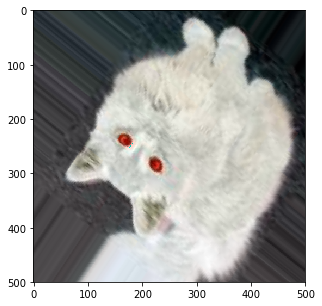

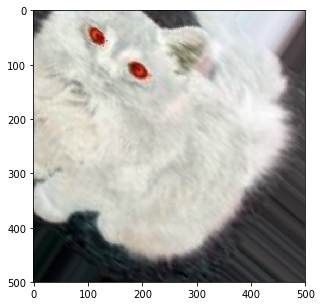

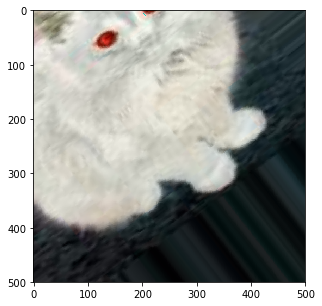

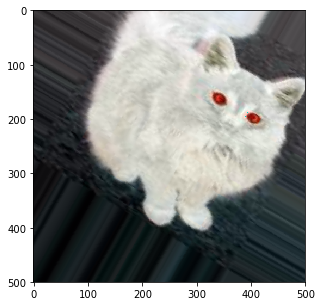

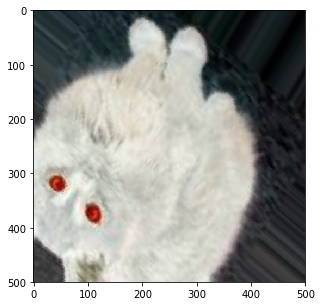

In [32]:
image_augment_generator = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip = True,
        fill_mode='nearest')



def sample_generator(samples, batch_size=1):
    
    while True:
        samples = shuffle(samples)
        num_samples = len(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset + batch_size]
            images = []
            one_hot_labels = []
            
            for sample in batch_samples:
                image = cv2.imread(sample[1])
                image = resize_image(image)

                images.append(image)
                one_hot_labels.append(sample[0])
                
                #plt.imshow(image)
                #plt.show()
                temp_img = image.reshape((1,) + image.shape)            

                for i in range(5):
                    augmented_image = next(image_augment_generator.flow(temp_img,   batch_size =3, save_to_dir="./data_gen"))[0, :]
                    plt.imshow(augmented_image)
                    plt.show()
                

                        
                
            
            X_train = np.array(images)
            y_train = np.array(one_hot_labels)
            
            #print("y_train", y_train)
            yield shuffle(X_train, y_train)
    
 

    
for i in range(1):
    next(sample_generator(raw_samples))

In [ ]:
def flow_setup():
    train_validation_samples, test_samples = train_test_split(raw_samples, test_size = 0.2, random_state = 42)
    train_samples, validation_samples = train_test_split(train_validation_samples, test_size = 0.2, random_state = 42)
    print("train sample count: ", len(train_samples), "\nvalidation sample count: ", len(validation_samples), "\ntest sample count: ", len(test_samples))
    print("sample data example:\n", train_samples[random.randint(0, len(train_samples))])
    
    train_generator = sample_generator(train_samples, batch_size = 32)
    validation_generator = sample_generator(validation_samples, batch_size = 32)
    test_generator = sample_generator(test_samples, batch_size = 32)
    
    model = model_setup(input_shape = (500, 500, 3), num_classes = len(LABEL_LIST))
    history_object = model.fit_generator(train_generator, samples_per_epoch= int(len(train_samples)), validation_data=validation_generator, nb_val_samples=len(validation_samples), nb_epoch=1, verbose=1)
    score = model.evaluate_generator(test_generator, 1500, max_q_size=10, nb_worker=1, pickle_safe=False)
    print(score)
    
    

flow_setup()    